# Criação do Modelo de Predição

> Neste notebook iremos criar um modelo de predição dos resultados da Copa do Mundo de 2022

In [1]:
# Importando bibliotecas necessárias
from dadosfera import *
import snowflake.connector
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from operator import itemgetter
import seaborn as sns

### 1. Recuperar dados do passo anterior

In [2]:
# Recuperando dados do passo anterior
data = dadosfera_utils.get_inputs() 

df = data['dict_df']['model_db']
team_stats_raw = data['dict_df']['team_stats_raw']

df.head()

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
2,Burkina Faso,Mali,0,28.0,0.0,0.0,0.0,0.0,-0.007459,16.0,16.0,-0.007459,-0.007459,0,1
3,Gabon,Ghana,1,16.0,0.0,0.0,0.0,0.0,-0.004183,28.0,28.0,-0.004183,-0.004183,0,1
10,Uganda,Tanzania,0,12.0,2.0,2.0,-2.0,-2.0,0.026630,-12.0,-12.0,0.037500,0.037500,0,1
18,Togo,Zimbabwe,1,47.0,-1.0,-1.0,-1.0,-1.0,-0.009804,-23.0,-23.0,0.002854,0.002854,1,0
23,Cameroon,Finland,1,-22.0,0.0,0.0,0.0,0.0,0.000000,-39.0,-39.0,0.002622,0.002622,1,0


### 2. Criar o modelo preditivo com o classificador Gradient Boosting

#### **O que é Gradient Boosting?**'
    Gradient Boosting é uma técnica de Machine Learning muito utilizada para regressão e classificação. Ela busca melhorar o resultado da predição ao utilizar diversos classificadores simples, como árvores de decisão, sempre escolhendo os classificadores que obtiveram os melhores desempenhos em cada caso.

Para entender o desempenho do modelo, iremos dividir aleatoriamente o nosso conjunto de dados na seguinte proporção: 80% treinamento e 20% teste.

In [3]:
X = df.iloc[:, 3:]
y = df[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

Definiremos a seguir o modelo e utilizaremos os dados de treinamento para treinar o nosso modelo.

In [4]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]} 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [5]:
gb = gb_cv.best_estimator_

In [6]:
gb

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=5, random_state=5)

### 3. Avaliar resultado do modelo
Para avaliar o resultado do nosso modelo, iremos utilizar a curva ROC e a matriz de confusão, que serão descritas logo abaixo.

In [15]:
def plot_auc(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(5,4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('Curva ROC')
    print('AUC score é %.2f em dados de teste e %.2f em dados de treinamento.'%(auc_test, auc_train))
    plt.show()
    
def plot_conf_matrix(model):
    fig, ax = plt.subplots(figsize=(5,4))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    ax.xaxis.set_ticklabels(['Derrota', 'Vitória'])
    ax.yaxis.set_ticklabels(['Derrota', 'Vitória']);
    ax.set_xlabel('Labels reais')
    ax.set_ylabel('Labels preditas')
    ax.set_title('Matriz de confusão')
    fig.show()

#### **O que é curva ROC?**
    ROC é uma curva de probabilidade e AUC representa o quão bem o modelo conseguiu separar as 2 classes, no nosso caso 'Vitória' e 'Derrota'. Quanto mais perto do canto superior esquerdo passa a cuva ROC no gráfico, melhor o desempenho dele, e, quanto maior o valor AUC, melhor o modelo é em prever corretamente essas classes.

AUC score é 0.76 em dados de teste e 0.79 em dados de treinamento.


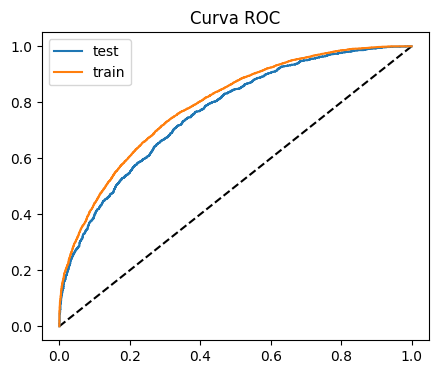

In [16]:
plot_auc(gb)

Quanto mais para cima e longe do meio a curva ROC estiver, melhores serão os resultados obtidos. 

Nesse caso obtivemos bons resultados! Um valor de AUC equivalente a 0,76 em dados de teste.
O modelo desempenhou melhor nos dados de treinamento, mas isso já era esperado visto que o modelo utiliza estes para entender os padrões nos dados.

#### **O que é matriz de confusão?**
    É uma visualização usada para analisar o desempenho de um classificador, contando as vezes em que o rótulo real e o rótulo previsto são iguais.
    Nesse sentido, quanto maiores os valores na diagonal melhor, pois representa os casos que ambos rótulos reais e preditos foram definidos como "Vitória" ou ambos foram definidos como "Derrota".

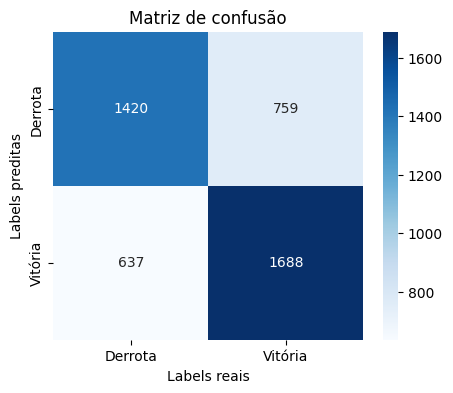

In [9]:
plot_conf_matrix(gb)

Nesta matriz de confusão, podemos ver que os maiores valores estão na diagonal composta por VitóriaxVitória e DerrotaxDerrota, o que também é um bom sinal, significa que o nosso modelo está acertando na classificação.

### 3. Exportar o dataset criado para o próximo passo

In [10]:
dict_df = {'df':df, 'team_stats_raw':team_stats_raw, 'model':gb}
dadosfera_utils.output(dict_df, name="dict_df")